(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
@load_pkg ActiveInference
# Import package to revise jlArchetype modules
using Revise

# Import project package
import ActiveInference as AI

# Import basic math
import StatsBase
import Distributions
import Random

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors

# Activate backend
CairoMakie.activate!()

# Set Plotting style
AI.viz.theme_makie!()

# A tutorial on the free-energy framework for modelling perception and learning

This notebook accompanies a series of notes based on the [2017 paper by
Bogacz](https://www.sciencedirect.com/science/article/pii/S0022249615000759).

## Simplest example of perception

Let us imagine an organism that is trying to determine the radius of an object
$r$ based on the light intensity. We assume the organism has a receptor that
gives a noisy readout of the **log** light intensity $I$. Let us then define
$$
g(r) = \ln r^2 = 2 \ln r,
\tag{1}
$$
be the non-linear function that relates the size of the object to the
log-intensity.

**Note**: *In the paper, the author uses only $g(r) = r^2$, but acknowledges that
then using a Gaussian distribution is problematic as it can take negative
values. Thus, I added the log to transform the variable.*


Let us then assume that for an object of size $r$, the organism's noisy receptor
gives a noisy readout of the form
$$
I \mid r \sim \mathcal{N}\left(g(r), \Sigma_i \right).
\tag{2}
$$
Given this level of noise, the organism uses prior knowledge---acquired by 
experience to encode its expectations on the size of the objects it perceives 
with this particular receptor. This prior is of the form
$$
r \sim \mathcal{N}\left(\left\langle r_p \right\rangle, \Sigma_p \right),
\tag{3}
$$
where the subscript $p$ represents "prior" information. Given a measurement, the
organism estimates the size of the object by computing Bayes' theorem
$$
\pi(r \mid I) = \frac{\pi(I \mid r) \pi(r)}{\pi(I)},
\tag{4}
$$
where the technical problem comes from computing the denominator
$$
\pi(I) = \int dr\; \pi(I \mid r) \pi(r).
\tag{5}
$$

Let us now assume that the organism gets to read out from its receptor a single
measurement:
- $I = 2$.
Furthermore, we assume the following parameters for the mean and variances:
- $\Sigma_i = 1$,
- $\left\langle r_p \right\rangle = 3$,
- $\Sigma_p = 1$.

To be able to compute Eq. 4, we first need a way to compute the integral in
Eq. 5. Let us define a function to compute this integral via a simple numerical
quadrature. 

In [3]:
@doc raw"""
    quad_midpoint(f, a, b, N)

Numerically integrates function `f` from `a` to `b` with `N` points.

# Arguments
- `f::function`: 1D-real-valued function to be integrated.
- `a::Real`: Integration lower limit.
- `b::Real`: Integration upper limit.
- `N::Int`: Number of steps to take
"""
function quad_midpoint(f::Function, a::Real, b::Real, N::Int)
    # Define width of each bin
    h = (b - a) / N

    # Initialize value of integral
    int = 0.0

    # Loop through steps
    for k = 1:N
        # Define mid point for k-th iteration
        xₖ_mid = (b - a) * (2k - 1) / (2N) + a
        # Add value of bin to integral.
        int += h * f(xₖ_mid)
    end # for

    return int
end # function

quad_midpoint

Next, let us define a function to evaluate the posterior distribution we want
to evaluate.

In [39]:
@doc raw"""
 π_r_I

Function to compute the posterior distribution π(r | I).

# Arguments
- `I::Real`: Value of the (log) intensity read by the detector.
- `r::Vector{<:Real}`: Object radius over which to evaluate the posterior dist.
- `Σᵣ::Real`: Value of the likelihood variance.
- `r̄ₚ::Real`: Mean of the prior distribution of object radius size.
- `Σₚ::Real`: Variance of the prior distribution of object radius size.

## Optional Keyword Arguments
- `g::Function`: Non-linear function mapping form radius to detector readout.
- `N::Int`: Number of bins used to perform the integration for the evidence.
  Default = 1000
"""
function π_r_I(
    I::Real,
    r::Vector{<:Real},
    Σᵢ::Real,
    r̄ₚ::Real,
    Σₚ::Real;
    g::Function=x -> log(x^2),
    N::Int=1000
)
    # Define prior distribution
    π_prior(r) = Distributions.pdf(Distributions.Normal(r̄ₚ, √(Σₚ)), r)
    # Define likelihood distribution
    π_likelihood(r) = Distributions.pdf(Distributions.Normal(g(I), √(Σᵢ)), r)
    # Define funcitn to compute integral for evidence / marginal likelihood
    π_evidence(r) = quad_midpoint(
        x -> π_likelihood(x) * π_prior(x),
        r[1],
        r[end],
        N
    )
    # Evaluate posterior for each value of r
    return [π_prior(x) * π_likelihood(x) / π_evidence(r) for x in r]
end # function

π_r_I

Having defined the function, let's look at the posterior distribution.

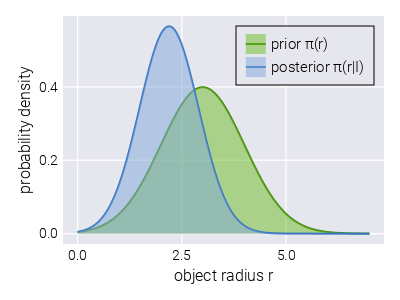

In [53]:
# Define ranges of r to evaluate
r = collect(LinRange(0, 7, 1000))

# Define parameters
I = 2
Σᵢ = 1
r̄ₚ = 3
Σₚ = 1

# Extract colors
color_palette = AI.viz.colors()

# Initialize figure
fig = Figure(resolution=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="object radius r",
    ylabel="probability density"
)

# Plot prior distribution
lines!(
    ax,
    r,
    Distributions.pdf.(Ref(Distributions.Normal(r̄ₚ, Σₚ)), r),
    label="prior π(r)",
    color=color_palette[:green]
)
fill_between!(
    ax,
    r,
    zeros(length(r)),
    Distributions.pdf.(Ref(Distributions.Normal(r̄ₚ, Σₚ)), r),
    label="prior π(r)",
    color=(color_palette[:light_green], 0.5)
)

# Plot posterior distribution
lines!(
    ax,
    r,
    π_r_I(I, r, Σᵢ, r̄ₚ, Σₚ),
    label="posterior π(r|I)",
    color=color_palette[:blue]
)

fill_between!(
    ax,
    r,
    zeros(length(r)),
    π_r_I(I, r, Σᵢ, r̄ₚ, Σₚ),
    label="posterior π(r|I)",
    color=(color_palette[:light_blue], 0.5)
)

# Add legend
axislegend(ax, unique=true, merge=true)

fig